## 新闻分类：多分类问题

本节任务描述：  
将路透社新闻划分为 46 个互斥的主题。因为有多个类别，所以这是多分类（multiclass classification）问题的一个例子。这是**单标签、多分类（single-label, multiclass classification）** 问题的一个例子。如果每个数据点可以划分到多个类别（主题），那它就是一个多标签、多分类（multilabel, 
multiclass classification）问题。

### 下载数据集
它包括 46 个不同的主题：某些主题的样本更多，但训练集中每个主题都有至少 10 个样本。，参数 num_words=10000 将数据限定为前 10 000 个最常出现的单词,有 8982 个训练样本和 2246 个测试样本。  
每个样本都是一个整数列表（表示单词索引）。


In [17]:
## 下载数据集
from keras.datasets import reuters

(train_data,train_labels),\
(test_data,test_labels)\
=reuters.load_data(path='reuters.npz',num_words=10000)



In [4]:
print(len(train_data))
print(len(test_data))
print(train_data[0])

8982
2246
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


### 准备数据

需要将列表转换为张量
- **填充列表：**使其具有相同的长度，再将列表转换成形状为 (samples, word_indices)的整数张量
- **one-hot 编码：**将其转换为 0 和 1 组成的向量。例如，序列 [3, 5] 将会被转换为 10 000 维向量，只有索引为 3 和 5 的元素是 1，其余元素都是 0。

In [6]:
# 数据编码
import numpy as np

def vectorize_sequence(sequences,dimension=10000):
    results = np.zeros((len(sequences),dimension))
    for i,sequence in enumerate(sequences):
        results[i,sequence] = 1.
    return results


In [7]:
x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)

In [8]:
def to_one_hot(labels,dimension=46):
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label] = 1.
    return results

In [12]:
# 将标签进行one hot 编码
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)


In [10]:
# 通过keras内置方法实现one hot 编码
from keras.utils.np_utils import to_categorical

keras_one_hot_train_labels = to_categorical(train_labels)
keras_one_hot_test_labels  = to_categorical(test_labels)


### 构建网络
输出类别的数量从 2 个变为 46 个。输出空间的维度要大得多。

需要确定架构
- 选择网络类型：全连接层（Dense）
- 网络层数：3层
- 每层网络的类型：64个隐藏单元,因为这里的需要分类46个类别，只要要大于46
    - 两个中间层，每层都有 64 个隐藏单元，使用relu作为激活函数
    - 第三层输出一个标量：使用 softmax 激活以输出一个 0~1 范围内的概率值
    
最后一层使用了 softmax 激活。你在 MNIST 例子中见过这种用法。网络将输出在 46个不同输出类别上的概率分布——对于每一个输入样本，网络都会输出一个46维向量，其中 output[i] 是样本属于第 i 个类别的概率。46个概率的总和为1。

**损失函数和优化器**
二分类问题，最好使用 binary_crossentropy（二元交叉熵）损失。
多分类问题，最好的损失函数是 categorical_crossentropy（分类交叉熵）衡量两个概率分布之间的距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。

In [16]:
from keras import models
from keras import layers
'''
Dense 函数
layers.Dense(
    units, # 神经元的个数
    activation=None, # 激活函数
    use_bias=True, # 使用bias
    kernel_initializer='glorot_uniform', # 神经元初始化方法
    bias_initializer='zeros', # bias初始化
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
'''

model = models.Sequential()

model.add(layers.Dense(64,activation = 'relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(46,activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
# 编译模型
model.compile(optimizer='rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

### 验证集的使用

在训练数据中留出 1000 个样本作为验证集

In [19]:
#创建验证集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [20]:
history = model.fit(partial_x_train,
                    partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s 461us/step - loss: 2.5267 - acc: 0.5043 - val_loss: 1.7143 - val_acc: 0.6110
Epoch 2/20
7982/7982 [==============================] - 1s 93us/step - loss: 1.4367 - acc: 0.6884 - val_loss: 1.3614 - val_acc: 0.6960
Epoch 3/20
7982/7982 [==============================] - 1s 94us/step - loss: 1.0939 - acc: 0.7652 - val_loss: 1.1757 - val_acc: 0.7500
Epoch 4/20
7982/7982 [==============================] - 1s 96us/step - loss: 0.8673 - acc: 0.8156 - val_loss: 1.0643 - val_acc: 0.7730
Epoch 5/20
7982/7982 [==============================] - 1s 98us/step - loss: 0.6923 - acc: 0.8515 - val_loss: 0.9927 - val_acc: 0.7860
Epoch 6/20
7982/7982 [==============================] - 1s 94us/step - loss: 0.5574 - acc: 0.8815 - val_loss: 0.9371 - val_acc: 0.8060
Epoch 7/20
7982/7982 [==============================] - 1s 93us/step - loss: 0.4470 - acc: 0.

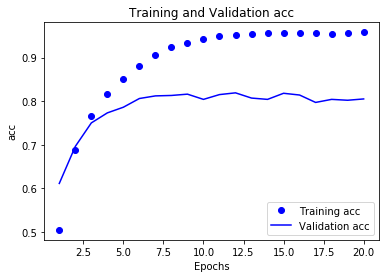

In [23]:
import matplotlib.pyplot as plt

loss = history.history['acc']
val_loss = history.history['val_acc']

epochs = range(1,len(loss) + 1)

plt.plot(epochs,loss,'bo',label = 'Training acc')
plt.plot(epochs,val_loss,'b',label = 'Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

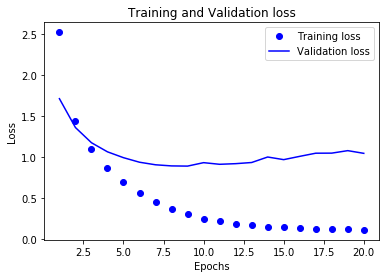

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss) + 1)

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 重新训练模型并预测结果

网络在训练 9 轮后开始过拟合。我们从头开始训练一个新网络，共 9 个轮次，然后在测试集上评估模型。



In [25]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64,activation = 'relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(46,activation = 'softmax'))

# 编译模型
model.compile(optimizer='rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 136us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 105us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 98us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 97us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 98us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 96us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 96us/step - loss: 0.4124 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8/9
79

In [30]:
predictions = model.predict(x_test)

print(predictions[0].shape)
print(np.sum(predictions[0]))
print(np.argmax(predictions[0]) )

(46,)
1.0
3


### 处理标签数据的两种方法

- 编码标签的方法，就是将其转换为整数张量
- 将标签编码为整数，然后使用 sparse_categorical_crossentropy 损失函数


In [ ]:
y_train_lable = np.array(train_labels)
y_test_label = np.array(test_labels)

# 使用的损失函数 categorical_crossentropy，标签应该遵循分类编码
model.compile(optimizer='rmsprop',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])


### 小结
- 如果要对 N 个类别的数据点进行分类，网络的最后一层应该是大小为 N 的 Dense 层。
- 对于单标签、多分类问题，网络的最后一层应该使用 softmax 激活，这样可以输出在 N个输出类别上的概率分布。
- 这种问题的损失函数几乎总是应该使用分类交叉熵。它将网络输出的概率分布与目标的真实分布之间的距离最小化。
- 处理多分类问题的标签有两种方法。
    - 通过分类编码（也叫 one-hot 编码）对标签进行编码，然后使用 categorical_crossentropy 作为损失函数。
    - 将标签编码为整数，然后使用 sparse_categorical_crossentropy 损失函数。
- 如果你需要将数据划分到许多类别中，应该避免使用太小的中间层，以免在网络中造成信息瓶颈。